In [1]:
import skimage
# Test per controllare la versione di Scikit che utilizzerò
skimage.__version__

import numpy as np

%matplotlib inline 
import matplotlib.pyplot as plt

#### Disabilito il limite di caricamento per immagini di grandi dimensioni 
In questo modo posso caricare immagini di grandi dimensioni, evitando Skimage DecompressionBombError (sul mio laptop anche un'immagine in jp2 da 17MB è riuscita a saturare la memoria rendendo impossibile il caricamento, ma altri computer non dovrebbero avere questo problema). 

Le mie domande adesso sono:
- Cosa c'entra PIL con il caricamento dell'immagine da skimage?
- Come ha fatto a riuscirci realmente?

In [2]:
from PIL import Image
# Disabilito il limite di caricamento per immagini di grandi dimensioni 
Image.MAX_IMAGE_PIXELS = None

from skimage import data
import os

# Split dell'immagine in tiles


In [3]:
def crop(source_image, height_box, width_box):
    # Assegna alle due variabili le dimensioni dell'immagine
    imgwidth, imgheight = source_image.size

    # Contatore per ordinare le tiles nella cartella di destinazione
    k = 1
    
    for row in range(0, imgheight, height_box):
        for column in range(0, imgwidth, width_box):

            # Creo un riquadro con le coordinate ricavate dai dati
            box = (column, row, column + width_box, row + height_box)

            # Utilizzo le precedenti coordinate per creare il tile
            tile = source_image.crop(box)

            # Salvo il riquadro (colonne x righe)
            tile.save("Tiles\\" + str(k) + "_[" + str(int(column/1000)) + "][" + str(int(row/1000)) + "].jp2")

            # Incremento il contatore
            k += 1

In [4]:
# Apertura dell'immagine
original_image = Image.open("Original\\striscio_completo.jp2")

In [5]:
crop(original_image, 1500, 1500)

# Applicazione dell'algoritmo di segmentazione

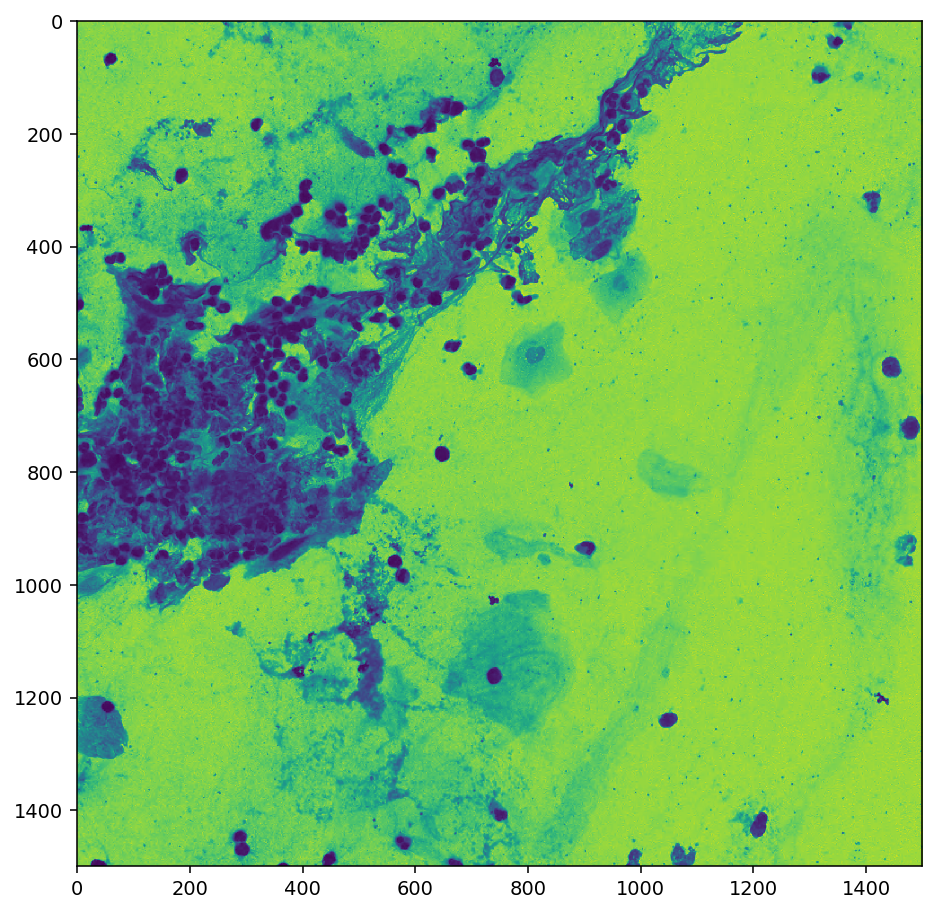

In [6]:
from skimage import data

# Utilizzo la scala di grigi per la rappresentazione dell'immagine
nucleus = data.load(os.getcwd() + "\\Tiles\\106.jp2", True)

# Ingrandisco l'immagine per una consultazione migliore
plt.figure(num=None, figsize=(8, 8), dpi=140, facecolor='w', edgecolor='k')

plt.imshow(nucleus);

C:\Users\anton\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


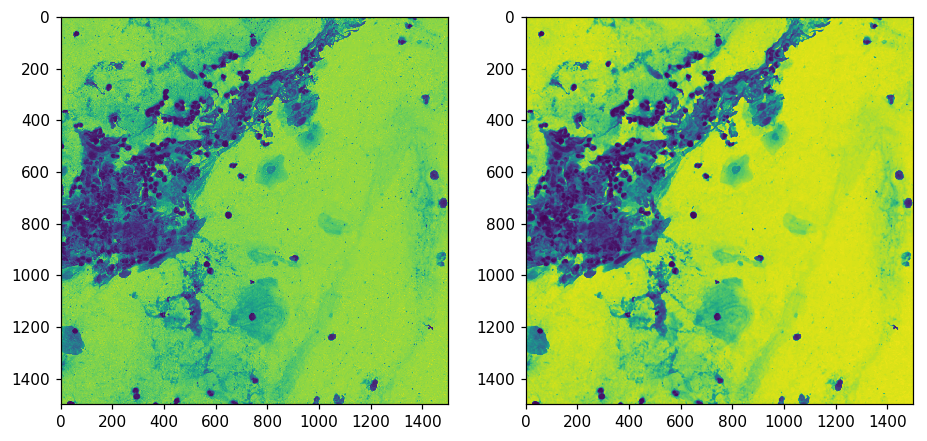

In [7]:
# Isoliamo adesso i nuclei dallo sfondo più scuro

# Andiamo adesso a levigare la superficie dei nuclei con il submodulo filters, eliminando il rumore dei dettagli
from skimage import filters

# Applico un median filter di grandezza 5x5 sull'immagine
# Return local median of an image
# selem : 2-D array, optional
# The neighborhood expressed as a 2-D array of 1’s and 0’s. If None, a full square of size 3 is used.
# np.ones(5, 5) = matrice unitaria 5x5
nucleus_denoised = filters.median(nucleus, selem = np.ones((5, 5)))

# In caso di errore: "ValueError: The parameter `image` must be a 2-dimensional array" assicurarsi che l'immagine sia 
# in scala di grigi

f, (ax0, ax1) = plt.subplots(1, 2, figsize = (10, 5), dpi = 110)
ax0.imshow(nucleus)
ax1.imshow(nucleus_denoised);

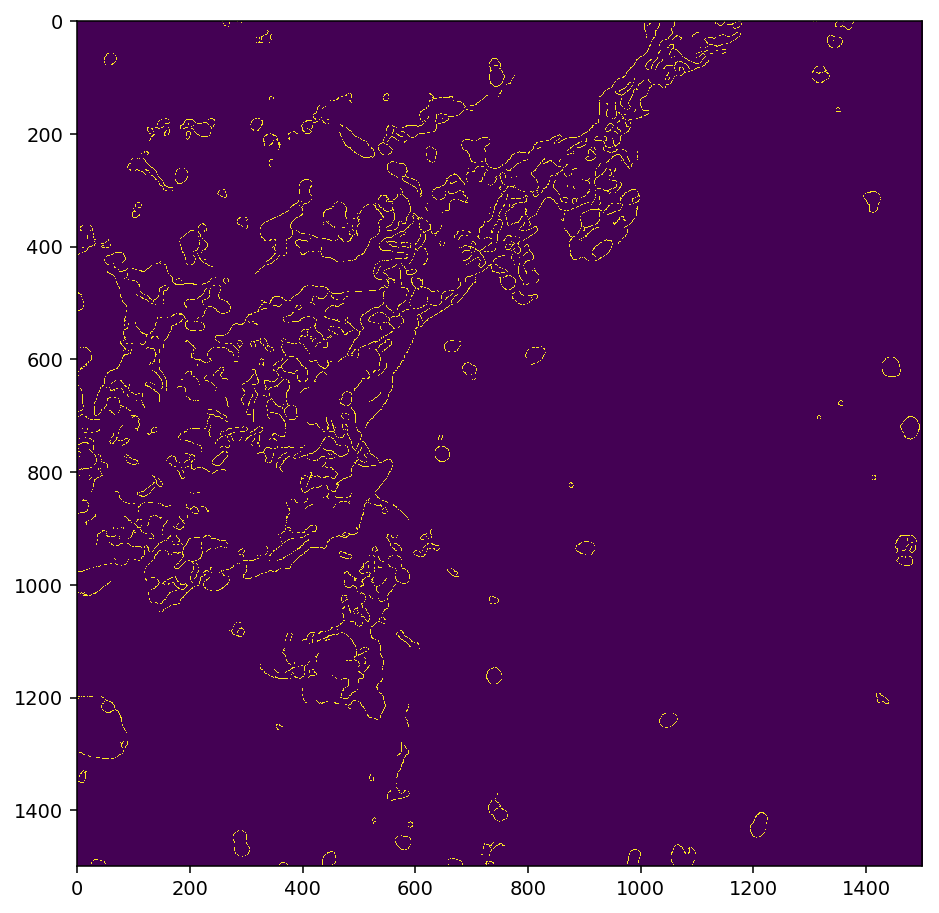

In [8]:
# Il prossimo passo è quello di trovare i bordi dei nuclei 

# Useremo il Canny Edge Detector dal submodulo feature
from skimage import feature

# Il paramentro sigma serve a regolare la larghezza dei bordi dei nuclei. Se il valore è troppo basso, andremo a cogliere come
# "bordo" anche il rumore interno al nucleo, mentre se il paramentro è troppo alto non riusciremo a cogliere il reale bordo
edges = skimage.feature.canny(nucleus_denoised, sigma = 3)

plt.figure(num=None, figsize=(8, 8), dpi=140, facecolor='w', edgecolor='k')
plt.imshow(edges);

# Segmentazione mediante watershed morfologica
Il concetto di watershed si basa sulla visualizzazione di un’immagine in tre dimensioni: due coordinate
spaziali e l’intensità. In questa interpretazione consideriamo tre punti chiave:
1. Punti che appartengono ad un minimo locale.
2. Bacino di raccolta (o watershed) del minimo: punti in cui una goccia d’acqua scorrerebbe verso uno
di tali minimi.
3. Linee di separazione (linee di watershed): punti in cui l’acqua potrebbe egualmente cadere in più di
un punto di minimo, che quindi formano le creste sulla superficie topografica.

L’obiettivo di questo metodo è quello di individuare le linee di watershed utilizzando il seguente sistema:
ogni minimo viene perforato e l’intera topografia viene riempita d’acqua dal basso lasciando che l’acqua
risalga uniforme attraverso questi fori (i minimi). Per prevenire la crescita del livello dell’acqua oltre i
contorni dell’immagine, si chiude il perimetro dell’immagine con delle dighe che hanno un’altezza maggiore
delle montagne, il cui valore viene determinato dal più alto valore di intensità presente nell’immagine.
Quando l’acqua dei differenti bacini rischia di debordare, viene costruita una diga al fine di prevenire tale
merging. Si continua con questo processo fino a raggiungere il massimo livello di allagamento (cioè il più
alto valore di intensità dell’immagine). La diga finale corrisponde alle linee di watershed, che corrispondono
al risultato della segmentazione desiderata, infatti le linee formano dei path connessi e di conseguenza dei
contorni continui tra le regioni; questo metodo elimina il problema delle linee di segmentazione
frammentate riscontrato in altri algoritmi.
Nota: tutto questo procedimento può essere fatto anche considerando l’acqua proveniente dall’alto, non
solo dai minimi.

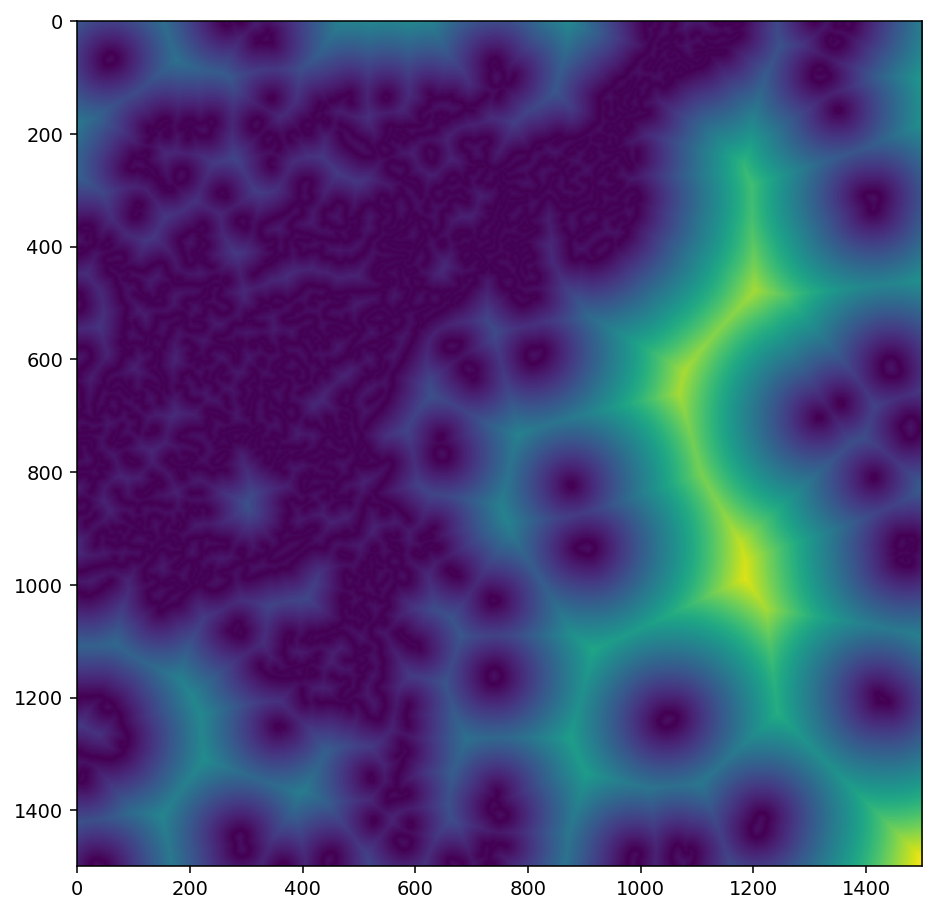

In [9]:
# Per applicare l'algoritmo di watershed dobbiamo convertire i bordi nell'immagine in un landscape e per questo utilizziamo
# la distance_transform implementata in scipy nel modulo ndimage

from scipy.ndimage import distance_transform_edt

# Eclidean distance transform chiamata sui negativi dei bordi 
# La distance transform è definita come la distanza dal pixel di sfondo più vicino
# Con il negativo rendiamo il background foreground e il foreground background
dt = distance_transform_edt(~edges)

# Quindi questo sarà il nostro landscape
plt.figure(num=None, figsize=(8, 8), dpi=140, facecolor='w', edgecolor='k')
plt.imshow(dt);

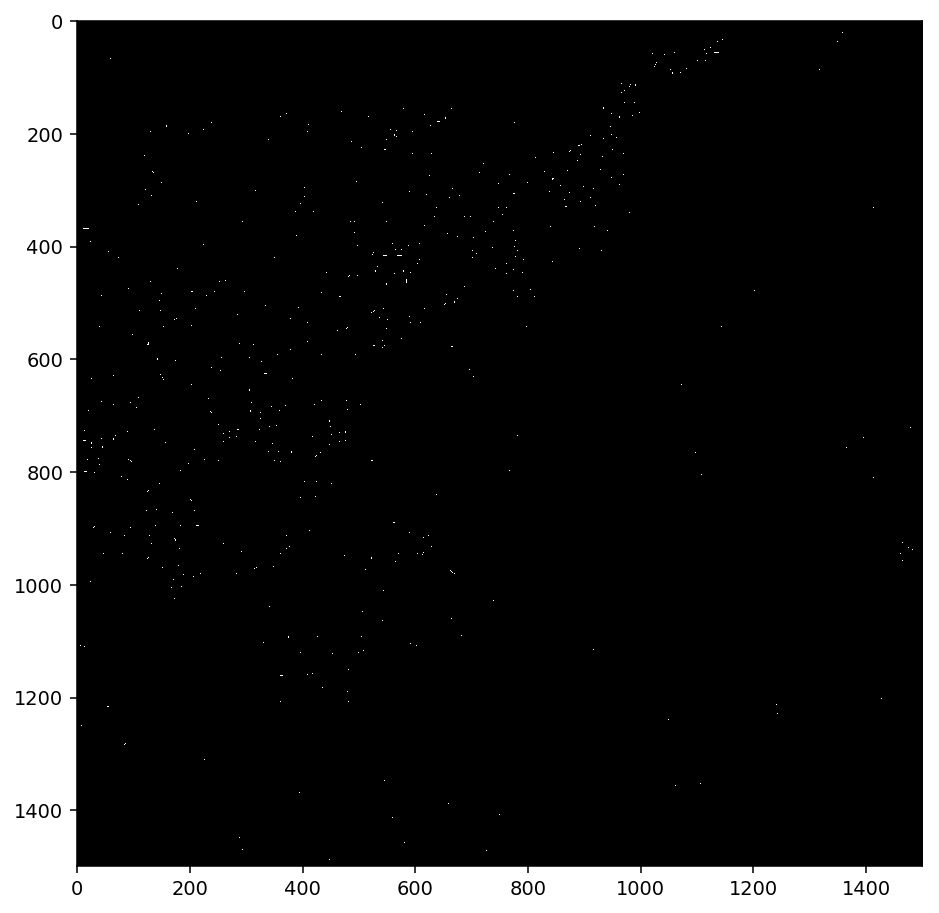

In [10]:
# Dobbiamo adesso trovare la locazione di queste fontane 
local_max = feature.peak_local_max(dt, indices = False, min_distance = 5)

plt.figure(num=None, figsize=(8, 8), dpi=140, facecolor='w', edgecolor='k')
plt.imshow(local_max, cmap = 'gray');

In [11]:
# Richiamiamo la stessa funzione di prima, ma questa volta con indices = True, che significa che ritornerà la posizione di ogni
# picco, invece del picco visualizzato come in figura
peak_idx = feature.peak_local_max(dt, indices = True, min_distance = 5)
peak_idx[:5]

array([[1494, 1074],
       [1488,  447],
       [1484,  987],
       [1483, 1026],
       [1482, 1026]], dtype=int64)

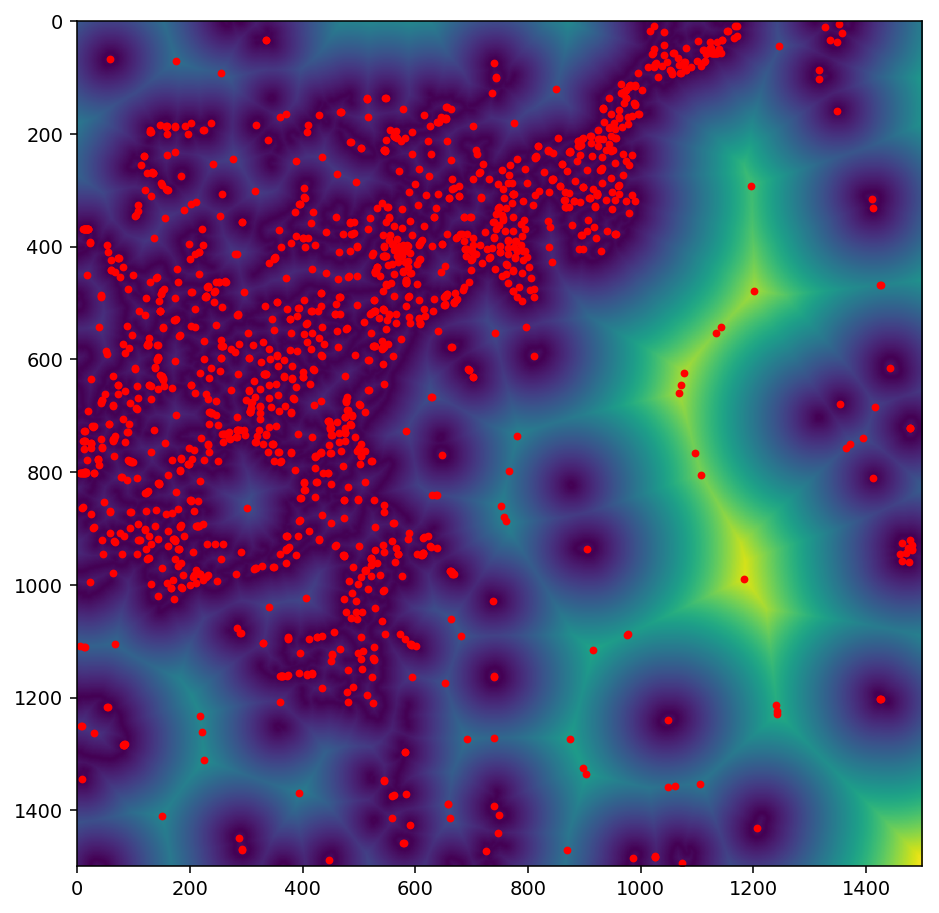

In [12]:
# Plottiamo quegli indici con matplotlib
plt.figure(num=None, figsize=(8, 8), dpi=140, facecolor='w', edgecolor='k')

# [:1] Coordinate X - [:0] Coordinate y
plt.plot(peak_idx[:,1], peak_idx[:,0], 'r.')

# Saranno mostrate le posizioni di queste fontane che saranno usate per allagare il landscape
plt.imshow(dt);

In [13]:
# Andiamo adesso a catalogare, numerare, ogni punto. Metodo usato dal Watershade per catalogare ogni regione intorno alla 
# fontana

from skimage import measure 
markers = measure.label(local_max)

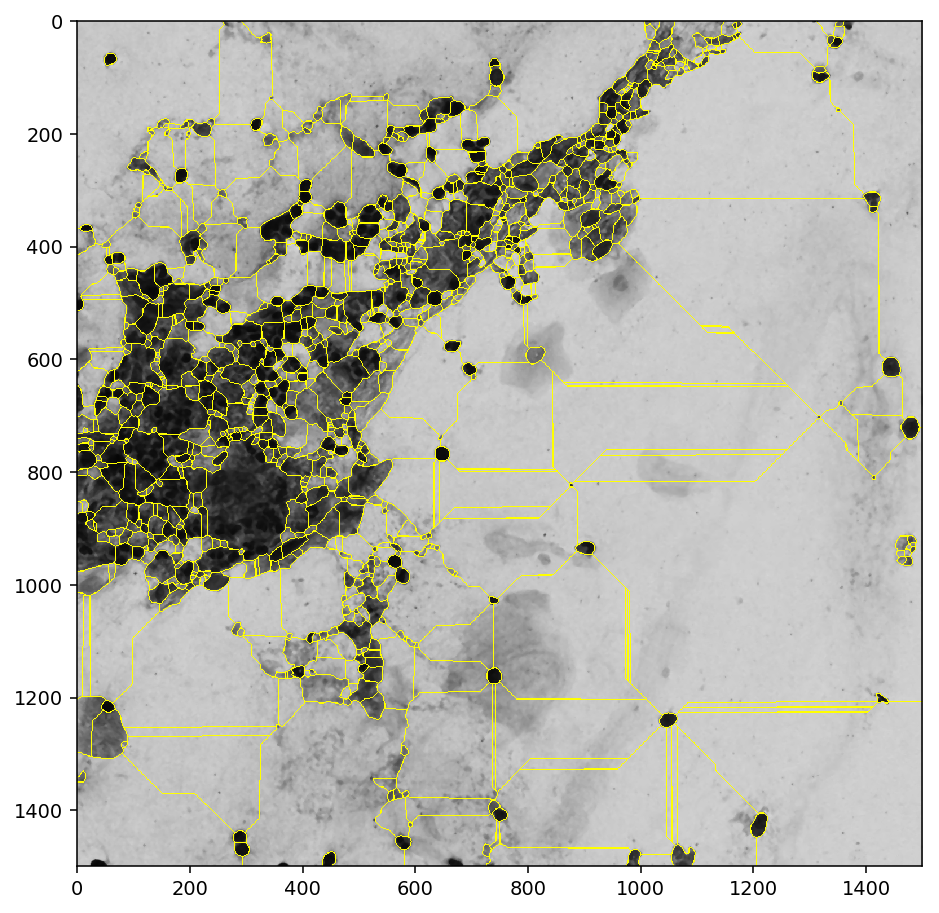

In [14]:
from skimage import morphology, segmentation

# Chiamiamo la nostra funzione di watershade sul negativo della nostra distanza dt.
# Di nuovo quindi, i bordi dei nuclei diventeranno i picchi, mentre il corpo del nucleo e lo sfondo, diventeranno landscape
labels = morphology.watershed(-dt, markers)

# Con mark_boundaries andremo a contornare i nuclei
plt.figure(num=None, figsize=(8, 8), dpi=140, facecolor='w', edgecolor='k')
plt.imshow(segmentation.mark_boundaries(nucleus_denoised, labels));

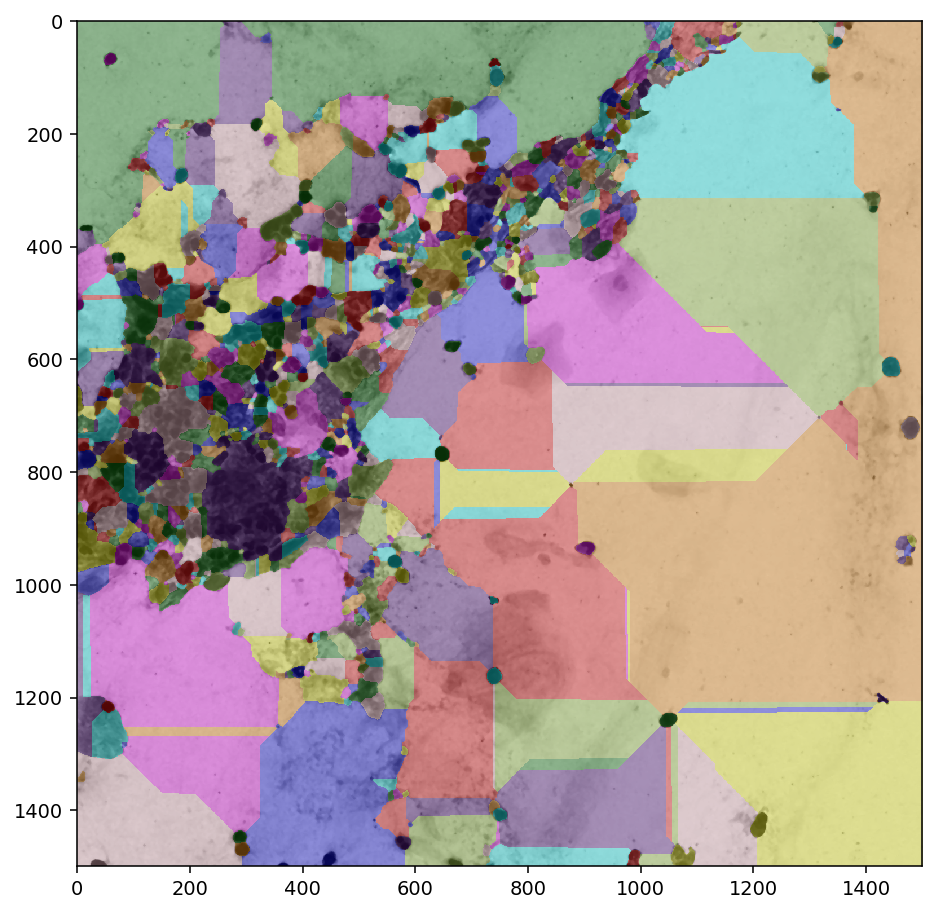

In [15]:
from skimage import color 

# La funzione label2rgb come la precedente funzione contorna i nuclei, questa volta però aggiungendo del colore
plt.figure(num=None, figsize=(8, 8), dpi=140, facecolor='w', edgecolor='k')
plt.imshow(color.label2rgb(labels, image = nucleus_denoised));

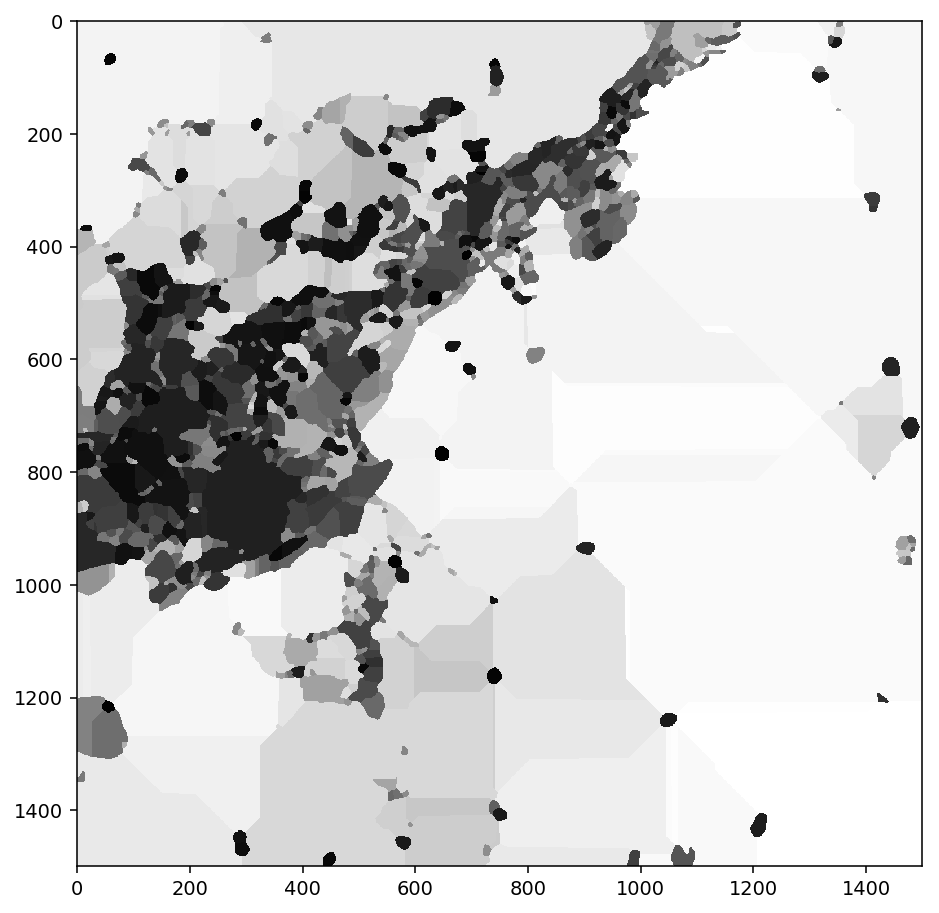

In [16]:
# Come possiamo adesso fondere le diverse regioni insieme, andando quindi a separare lo sfondo dai vari nuclei?

# Invece di usare i colori per rappresentare le aree, per mediare i valori dei pixel useremo ancora una volta label2rgb
# Adesso possiamo vedere come i nuclei sono più chiari dello sfondo, quindi dovremmo essere in grado di separare foreground 
# e background osservando le loro intensità di colori 
plt.figure(num=None, figsize=(8, 8), dpi=140, facecolor='w', edgecolor='k')
plt.imshow(color.label2rgb(labels, image = nucleus_denoised, kind = 'avg'), cmap = 'gray');

In [17]:
# Osserviamo adesso tutte le regioni trovate nell'immagine precedente. Regionprops sarà calcolato per ogni immagine che vediamo
# Per ogni regionprops possiamo adesso calcolare l'area, il bounding box, l'area del bounding box, il centroide...
# Per scoprire le altre funzioni utilizzabili, digitiamo "measure.regionprops?"
regions = measure.regionprops(labels, intensity_image = nucleus_denoised)

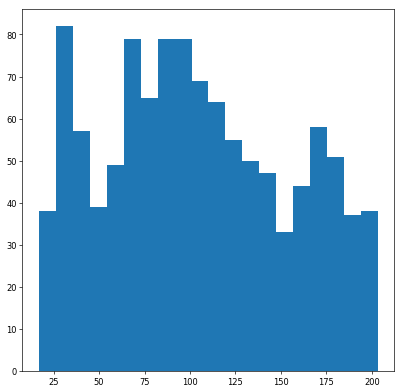

In [18]:
# adesso calcoliamo l'intensità media per ciascuna di queste regioni 
region_means = [r.mean_intensity for r in regions]

plt.figure(num=None, figsize=(8, 8), dpi=60, facecolor='w', edgecolor='k')
plt.hist(region_means, bins = 20);

A sinistra possiamo vedere l'intensità media degli oggetti associati con il background, mentre a destra quelli in foreground, ovvero i nuclei. Se li dividiamo intorno al valore X dovremmo avere una segmentazione buona. Tutto ciò se lo facciamo "a mano", mentre noi vogliamo che questi processi siano automatizzati, quindi utilizzeremo sklearn e faremo un clustering  delle intensità del background e del foreground 

In [19]:
from sklearn.cluster import KMeans
# Chiediamo a KMeans che siamo interessati a due cluster
model = KMeans(n_clusters = 2)

# Convertiamo le informazioni ricavate in un array 
region_means = np.array(region_means).reshape(-1, 1)

In [20]:
try:
    model.fit(region_means)
    
    # Adesso calcoliamo il valore centrale dei due cluster trovati
    print(model.cluster_centers_)
    
except ValueError as e:
    print('Failed1: '+ str(e))
except AttributeError as w:
    print('Failed2: '+ str(e))


[[153.01036827]
 [ 66.71245317]]


In [21]:
# Chiediamo adesso al nostro modello di predire le label per ogni regione 
bg_fg_labels = model.predict(region_means)
bg_fg_labels

array([1, 0, 1, ..., 1, 1, 1])

In [22]:
# Classifichiamo le immagini in modo appropriato 

# Copiamo le nostre etichette originali 
classified_labels = labels.copy()

# Useremo poi la combinazione tra le nostre etichette predette con le diverse regioni e le riclassificheremo secondo le 
# coordinate di ogni regione, e assegneremo un valore di background o foreground 
for bg_fg, region in zip(bg_fg_labels, regions):
    classified_labels[tuple(region.coords.T)] = bg_fg

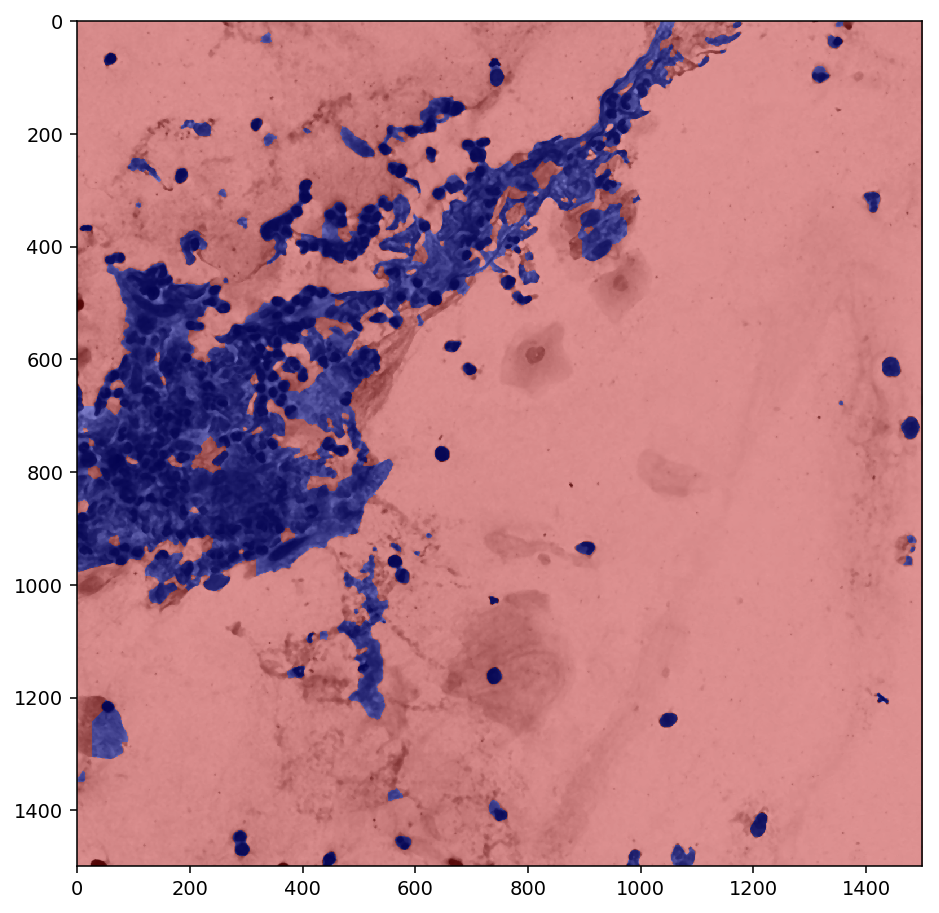

In [23]:
result = color.label2rgb(classified_labels, image = nucleus_denoised)
plt.figure(num=None, figsize=(8, 8), dpi=140, facecolor='w', edgecolor='k')
plt.imshow(result);

In [24]:
rows, cols, bands = result.shape
X = result.reshape(rows*cols, bands)

kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
labels_div = kmeans.labels_.reshape(rows, cols)

nucleus = 0

for i in np.unique(labels_div):
    blobs = np.int_(morphology.binary_opening(labels_div == i))
    count = len(np.unique(measure.label(blobs))) - 1
    if count > nucleus:
        nucleus = count

print(nucleus)

132
